# Network Metrics and Algorithms

[Alex Hanna](http://alex-hanna.com), University of Toronto/Google

In this module, you will learn a number of metrics for network analysis. We have the following objectives:

- Learn how to calculate a number of network-level metrics, such as density and assortativity
- Understand node-level metrics, namely the different types of centrality
- Differentiate between different types of group-level and algorithms, such as community detection and k-core decomposition

We're moving now from inspecting networks visually into interpreting them quantitatively. There are several levels at which we can do this analysis and interpretation: we can start at the network or graph-wide level, then drill down into the node-level, and finally into the group level. Each has its own purpose; it depends greatly what claims you'd like to make about the network to decide which approach to use. 

## Network-level metrics

Not often, but some of the time we want to make somes statement about the network as a whole. We're going to work with two different types of hypothetical networks in order to illustrate some basic network properties. The first will be a Barabasi-Albert preferential attachment (PA) network. The other will be a Watts-Strogatz small-world (SW) network.

In [5]:
library(igraph)

In [69]:
net.pa <- sample_pa(100)
net.sw <- sample_smallworld(dim = 2, size = 10, nei = 1, p = 0.1)

In [70]:
summary(net.pa)

IGRAPH d3e44e6 D--- 100 99 -- Barabasi graph
+ attr: name (g/c), power (g/n), m (g/n), zero.appeal (g/n), algorithm
| (g/c)


In [71]:
summary(net.sw)

IGRAPH 078722a U--- 100 200 -- Watts-Strogatz random graph
+ attr: name (g/c), dim (g/n), size (g/n), nei (g/n), p (g/n), loops
| (g/l), multiple (g/l)


These networks have the same number of nodes, but the PA graph is directed while the SW graph is undirected. The PA graph has 99 edges, and the SW graph has 200 edges. Let's visualize them.

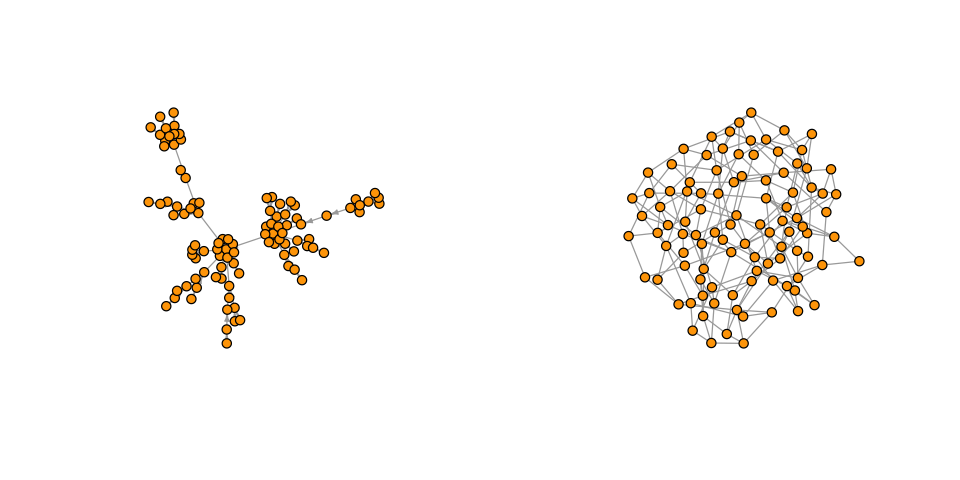

In [72]:
## plot two figures in one row
par(mfrow=c(1,2))

## shrink a bit 
options(repr.plot.width = 8, repr.plot.height = 4)

plot(net.pa, vertex.color = "orange", vertex.size = 8, vertex.label = NA, edge.arrow.size = 0.3)
plot(net.sw, vertex.color = "orange", vertex.size = 8, vertex.label = NA)

Without knowing any of the theory behind these networks, we can already tell that these are two very different types of networks. The preferential attachment network looks much more like a spoke-type network with a few critical nodes, while the small-world network is much more densely connected. The first metric we will use to evaluate the differences here is **density**. Density is the proportion of edges which exist divided by the possible edges which can exist. We'd expect the SW graph to be more dense then the PA one.

In [73]:
print(paste("PA density:", edge_density(net.pa, loops = F), ";",
            "Small-world density:", edge_density(net.sw, loops = F)))

[1] "PA density: 0.01 ; Small-world density: 0.0404040404040404"


While this may not be helpful on its own for a global network, it could be helpful in identifying if particular clusters of nodes are denser than others. We'll do this in the example.

Another network-wide metric we can use is **transitivity**. A connection is transitive if a triad -- that is, three nodes -- if it is complete. In our basic graph literal language -- if `A->B` and `B->C`, then we expect `C->A`. Based on our visual, it looks like the SW network will be much more transitive.

In [74]:
print(paste("PA network transitivity:", transitivity(net.pa, type = "global"), ";",
            "Small-world transitivity:", transitivity(net.sw, type = "global")))

[1] "PA network transitivity: 0 ; Small-world transitivity: 0.0190174326465927"


This could be helpful in identifying or predicting links between nodes. Imagine the recommender systems which see on social networking sites. Guessing which link should be transitive can be part of this system's functioning.

For directed networks, we can identify the degree to which directed edges are reciprocated. It doesn't look like there are any reciprocated edges in the PA network.

In [75]:
reciprocity(net.pa)

[1] 0

## Path-level metrics

A **path** in a network is any chain of edges and nodes which gets from one node to another. In graph theory, there's a number of algorithms which have to do with finding the shortest distance between any two nodes (e.g. A*, Djikstra's algorithm). While it may not be readily apparent why that may be interesting in social or political networks, we will see one use for shortest path algorithms below when we discuss centrality.

#### Distances and shortest paths

We can use `mean_distance` to find the mean distances of the whole network.  A **geodesic** is a shortest path between any two points in a network. The **diameter** of a graph is the length of the longest geodesic.

In [125]:
print(paste("Mean distance of PA: ", mean_distance(net.pa), ";", 
            "Mean distance of SW: ", mean_distance(net.sw)))

[1] "Mean distance of PA:  2.15555555555556 ; Mean distance of SW:  3.80707070707071"


In [126]:
print(paste("Diameter of PA: ", diameter(net.pa), ";", 
            "Diameter of SW: ", diameter(net.sw)))

[1] "Diameter of PA:  6 ; Diameter of SW:  7"


We can use `shortest_path` to find the shortest path between two nodes.  We'll use a ring network to illustrate a trivial case.

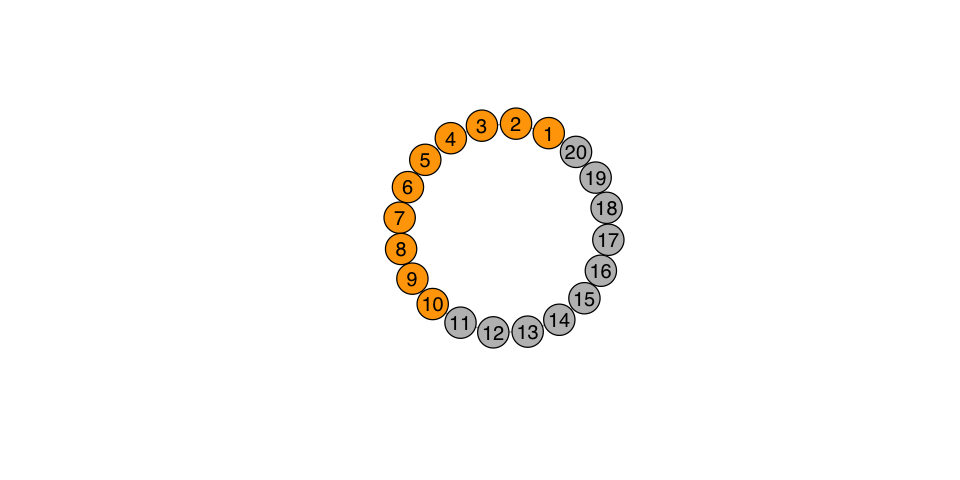

In [209]:
## back to one-a-row
par(mfrow=c(1,1))

net.ring <- make_ring(20)
my_path <- shortest_paths(net.ring, 1, 10)$vpath[[1]]
V(net.ring)$color <- "gray"
V(net.ring)$color[my_path] <- "orange"
plot(net.ring, vertex.label.family = "Helvetica", vertex.label.color = "black", vertex.size = 30)

### Exercise 1

1. Let's load up the Swiss parliamentary cosponsorship network once again and generate community structures for them.

In [258]:
## Loading Conseil National data
data.conseil = read.csv('data/net_ch_cn1995-1999.csv', header = TRUE, as.is = TRUE)
conseil.net = graph_from_edgelist(as.matrix(data.conseil), directed = FALSE)

conseil.clp <- cluster_fast_greedy(conseil.net)
V(conseil.net)$community <- conseil.clp$membership 

Now, let's take each of these communities as their own subgraphs. We can do this by selecting only the nodes which fall into each membership group using `induced_subgraph` to form a subgraph.

In [ ]:
conseil.net1 <- induced_subgraph(conseil.net, V(conseil.net)[community == 1])
conseil.net2 <- induced_subgraph(conseil.net, V(conseil.net)[community == 2])
conseil.net3 <- induced_subgraph(conseil.net, V(conseil.net)[community == 3])

Now, calculate the density and transitivity of each of these subgraphs. Which of these networks is the most dense? Which is the most transitive?

<dd>2. What's the diameter of the whole Conseil National network? What is the mean distance?<dd>

<dd>3. Using the interactive tool, we found that in the 1995-99 Conseil National, Ruth Genner of the Green Party had 2 cosponsors on 2 bills. Meanwhile, Peter Hess of the Christian Democratic People's Party had one cosponsor on 1 bill. Complete the following code below to find the shortest path between them and plot it.</dd>

In [ ]:
____ <- ____(conseil.net, "Ruth Genner", "Peter Hess")$vpath[[1]]
V(conseil.net)$color <- "gray"
V(conseil.net)$color[____] <- "orange"
plot(conseil.net, 
     vertex.label.family = "Helvetica", 
     vertex.label.color = "black", 
     vertex.size = 8, 
     vertex.label = ifelse(V(conseil.net)$name %in% c("Ruth Genner", "Peter Hess"), V(conseil.net)$name, NA),
     vertex.label.cex = 0.75,
     vertex.label.dist = 2,
     layout = layout_nicely)

<dd>4. Print out this path between these two MPs. How long is it?</dd> 

## Node-level metrics -- Centrality

Say we'd like to understand who the most important node in the network is, or find the group of most influential node, those who are the elites of communication. This is where the concept of centrality comes in. Centrality is a metric in social network analysis which attempts to find the most important node in a given network. There's many different ways to do this, but we're going to focus on four types: degree, betweenness, closeness, and eigenvector centrality.

### Degree, betweenness, and closeness centrality

Degree centrality is the simplest measure of centrality. It is a measure of how many edges are connected to a particular node. We can further more decompose degree into **indegrees** and **outdegrees** in a directed network. In-degree is the number of edges going into a node, while out-degree is the number of edges going out of the node. If we were dealing with Twitter data, this would be the number of times a user was retweeted versus the number of times they were retweeted.

Betweenness centrality is similar but a bit different. Instead of measuring degree, betweenness centrality measures how many shortest paths between pairs of nodes need to pass through any given node. Think of a major transit hub. It doesn't have to have many inbound planes to be important, but if it connects cities from many parts of the world to each other, it would have high betweenness centrality.

Closeness centrality is related a bit more to betweenness centrality. It is calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.

Let's return to the Paul Revere dataset and work with the one-mode person network.

In [227]:
data.revere <- as.matrix(read.csv("data/PaulRevereAppD.csv", row.names = 1))
person.net <- data.revere %*% t(data.revere)
revere.person.g <- graph.adjacency(person.net, mode="undirected", weighted=NULL, diag=FALSE)
revere.person.g <- simplify(revere.person.g)

V(revere.person.g)$label = NA
V(revere.person.g)$color = 'gray'
E(revere.person.g)$color = 'gray90'

Let's calculate the degree, betweenness, and closeness centrality of this network and use it as a metric for the size.

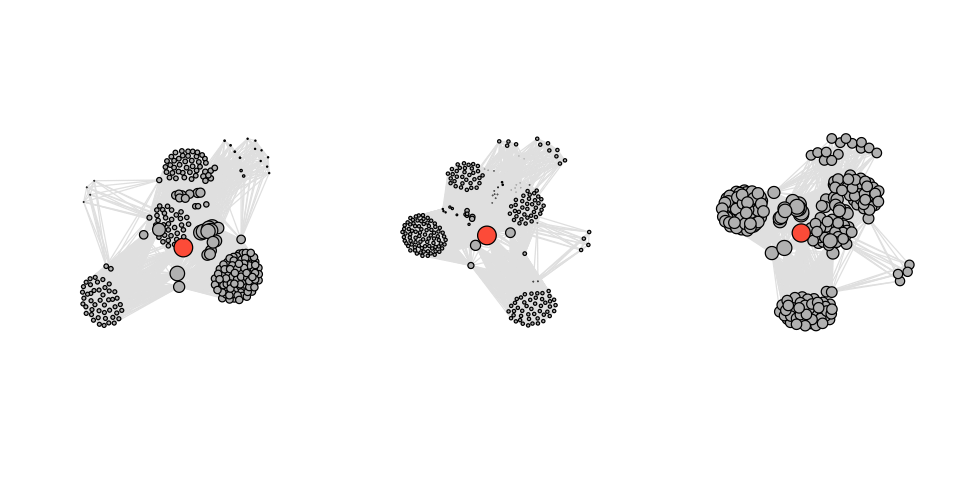

In [257]:
### three a row
par(mfrow = c(1,3))

## identify Revere
V(revere.person.g)$color <- ifelse(V(revere.person.g)$name == 'Revere.Paul', 'tomato', 'gray')

## plot degree centrality
revere.degree_centrality <- centr_degree(revere.person.g, mode = "all", normalized = T)
V(revere.person.g)$size <- (revere.degree_centrality$res / max(revere.degree_centrality$res))*20
plot(revere.person.g)

## plot betweenness centrality
revere.between_centrality <- centr_betw(revere.person.g, normalized = T)
V(revere.person.g)$size <- (revere.between_centrality$res / max(revere.between_centrality$res))*20
plot(revere.person.g)

## plot closeness centrality
revere.closeness_centrality <- centr_clo(revere.person.g, mode="all", normalized=T)
V(revere.person.g)$size <- revere.closeness_centrality$res * 20
plot(revere.person.g)

These three graphs look similar. However, while the degree centrality graph looks more or less identical to the degree plots we were doing earlier, the betweenness centrality graph highlights much more than the others the central role of Revere and how he operated as a broker between different organizations. The closeness centrality graph, however, seems to obscure some of that importance.

### Eigenvector centrality

Eigenvector centrality is predicated on the notion that the relative centrality is a function of the centralities of nodes to which it is connected. 

In [244]:
## only one!
par(mfrow = c(1,1))

revere.eigenvector_centrality <- centr_eigen(revere.person.g, directed = F, normalized = T)

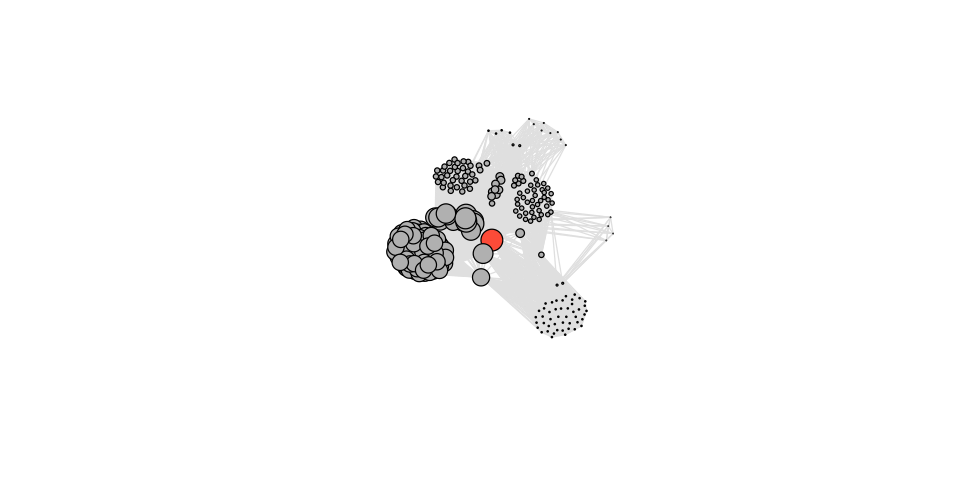

In [247]:
V(revere.person.g)$size <- revere.eigenvector_centrality$vector * 20
plot(revere.person.g)

While this highlights the importance of Revere, it also highlights the importance of a cluster of highly interconnected individuals close by.

### Degree distributions

So far we've dealt with each of these node-level attributes in isolate. We can also aggregate these metrics, which can tell us a little bit more about the network.

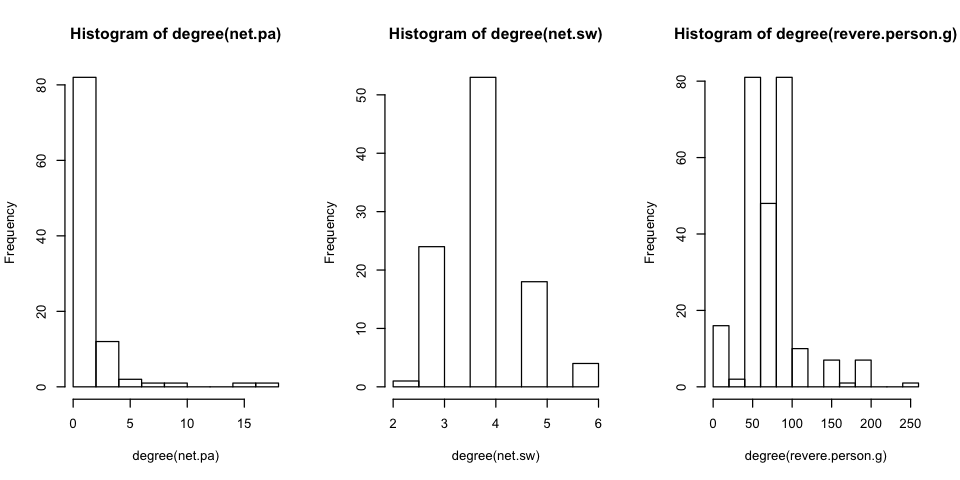

In [256]:
par(mfrow=c(1,3))

hist(degree(net.pa))
hist(degree(net.sw))
hist(degree(revere.person.g))

Plotting a histogram of degree tells us a bit about the nature of each of these networks. Looking at the preferential attachment network, the degree tends to be left-skewed, indicating a low number of highly connected nodes. For the small-world network, most nodes have four connections. In our Revere network, many nodes have somewhere from 50 to 100 connections, but a few have between 150 and 250.

### Exercise 2

<dd>1. Calculate the degree, betweenness, closeness, and eigenvector centrality for the `conseil.net` network. We'll store this in the `conseil.centrality` data frame.</dd>

In [ ]:
## create new data frame
conseil.centrality = data.frame(id = V(conseil.net)$name)

## calculate centrality
conseil.centrality$degree <- ____(____, mode = "all", normalized = T)$res
conseil.centrality$betwn  <- ____(____, directed = F, normalized = T)$res
conseil.centrality$close  <- ____(____, mode = "all", normalized = T)$res
conseil.centrality$eigen  <- ____(____, directed = F, normalized = T)$vector

## actually normalize degree and betwn
conseil.centrality$degree <- conseil.centrality$degree / max(conseil.centrality$degree)
conseil.centrality$betwn  <- conseil.centrality$betwn / max(conseil.centrality$betwn)

<dd>2. The below code plots a matrix of scatter plots between each type of centrality. Which types of centrality seem to be most closely correlated?</dd>

In [ ]:
pairs(conseil.centrality[,2:5], lower.panel = NULL)

<dd>3. Sort the data frame based on each type of centrality, descending. Who are the people who seem to have the highest centrality for each metric? Write the parliamentarian at the top of the list down. Which one is not like the other?</dd>

In [ ]:
## order by degree centrality, decreasing
head(conseil.centrality[order(-conseil.centrality$betwn),])

In [ ]:
## order by betweenness centrality, decreasing
head(conseil.centrality[order(-____$____),])

In [ ]:
## order by closeness centrality, decreasing
head(conseil.centrality[order(-____$____),])

In [ ]:
## order by eigenvector centrality, decreasing
head(conseil.centrality[order(-____$____),])

<dd>4. Let's compare all four types of centrality. We're going to create a 2x2 plot which illustrates all four networks, each highlighting centrality by size and the person with the highest centrality for each.</dd>

In [ ]:
## sets up the 2x2 plot table
par(mfrow=c(1,2))

## set up defaults
V(conseil.net)$label = NA
V(conseil.net)$color = "gray"

## degree centrality
## set the size based on degree centrality
V(conseil.net)$____ = ____$____*20

## highlight the top individual for degree centrality
V(conseil.net)$color = ifelse(_(conseil.net)$____ == ____, "red", "gray")
plot(conseil.net)

## betweenness centrality
## set the size based on betweenness centrality
V(conseil.net)$___ = ____$____*20

## highlight the top individual for betweenness centrality
V(conseil.net)$color = ifelse(_(conseil.net)$____ == ____, "red", "gray")
plot(conseil.net)

## closeness centrality
## set the size based on closeness centrality
V(conseil.net)$___ = ____$____*20

## highlight the top individual for closeness centrality
V(conseil.net)$color = ifelse(_(conseil.net)$____ == ____, "red", "gray")
plot(conseil.net)

## eigenvector centrality
## set the size based on eigenvector centrality
V(conseil.net)$___ = ____$____*20

## highlight the top individual for eigenvector centrality
V(conseil.net)$color = ifelse(_(conseil.net)$____ == ____, "red", "gray")
plot(conseil.net)

## Group-level metrics - Community detection

- Community detection
    - k-core decomposition
    
- Exercise here